### 1: Setup - Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


### 2: Data Loading and Initial Inspection

In [3]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 1.40 MiB | 4.50 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/netflix_titles.csv')
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [6]:
df.isna().sum()

,0
show_id,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0


In [7]:
missing_data_column = df.columns[df.isna().sum() > 0]

In [8]:
print(missing_data_column)

Index(['director', 'cast', 'country', 'date_added', 'rating'], dtype='object')


In [9]:
for column in missing_data_column:
  print(df[column].dtype)
  # df[column].fillna(df[column].mode()[0], inplace=True)

object
object
object
object
object


### 3: Data Cleaning and TransformationData

In [10]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')

In [11]:
df.isnull().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,507
date_added,10
release_year,0
rating,7
duration,0


In [12]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

In [13]:
df.dropna(subset=['date_added', 'rating'], inplace=True)

In [14]:
df.isnull().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,0
date_added,0
release_year,0
rating,0
duration,0


In [15]:
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=False)

### 4: Feature Engineering

In [16]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

### Q1. How has the distribution of content ratings changed over time?

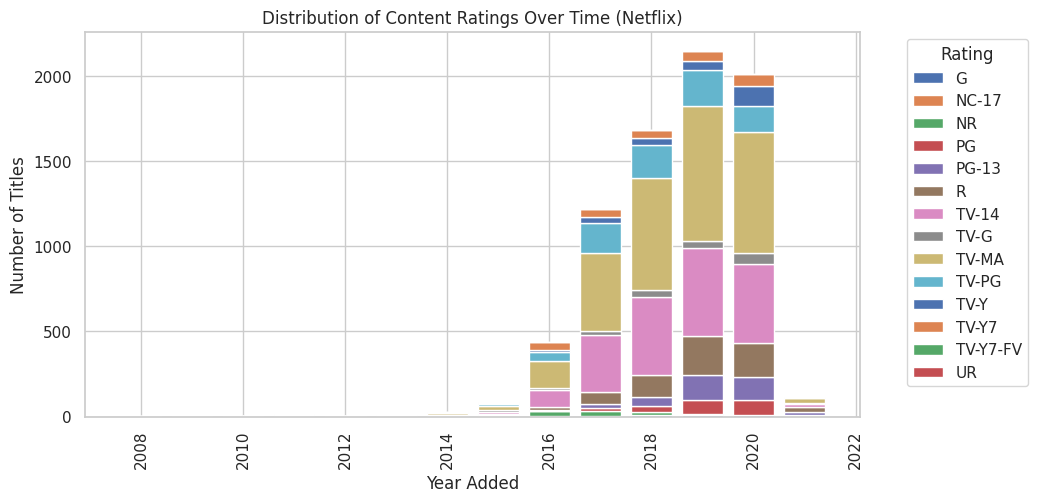

In [62]:
rating_trends = df.groupby(['year_added', 'rating']).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
bottom = None

for col in rating_trends.columns:
    plt.bar(
        rating_trends.index,
        rating_trends[col],
        label=col,
        bottom=bottom
    )
    bottom = rating_trends[col] if bottom is None else bottom + rating_trends[col]

plt.title("Distribution of Content Ratings Over Time (Netflix)")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.xticks(rotation=90)
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

### Q2. Is there a relationship between content age and its type (Movie vs. TV Show)?

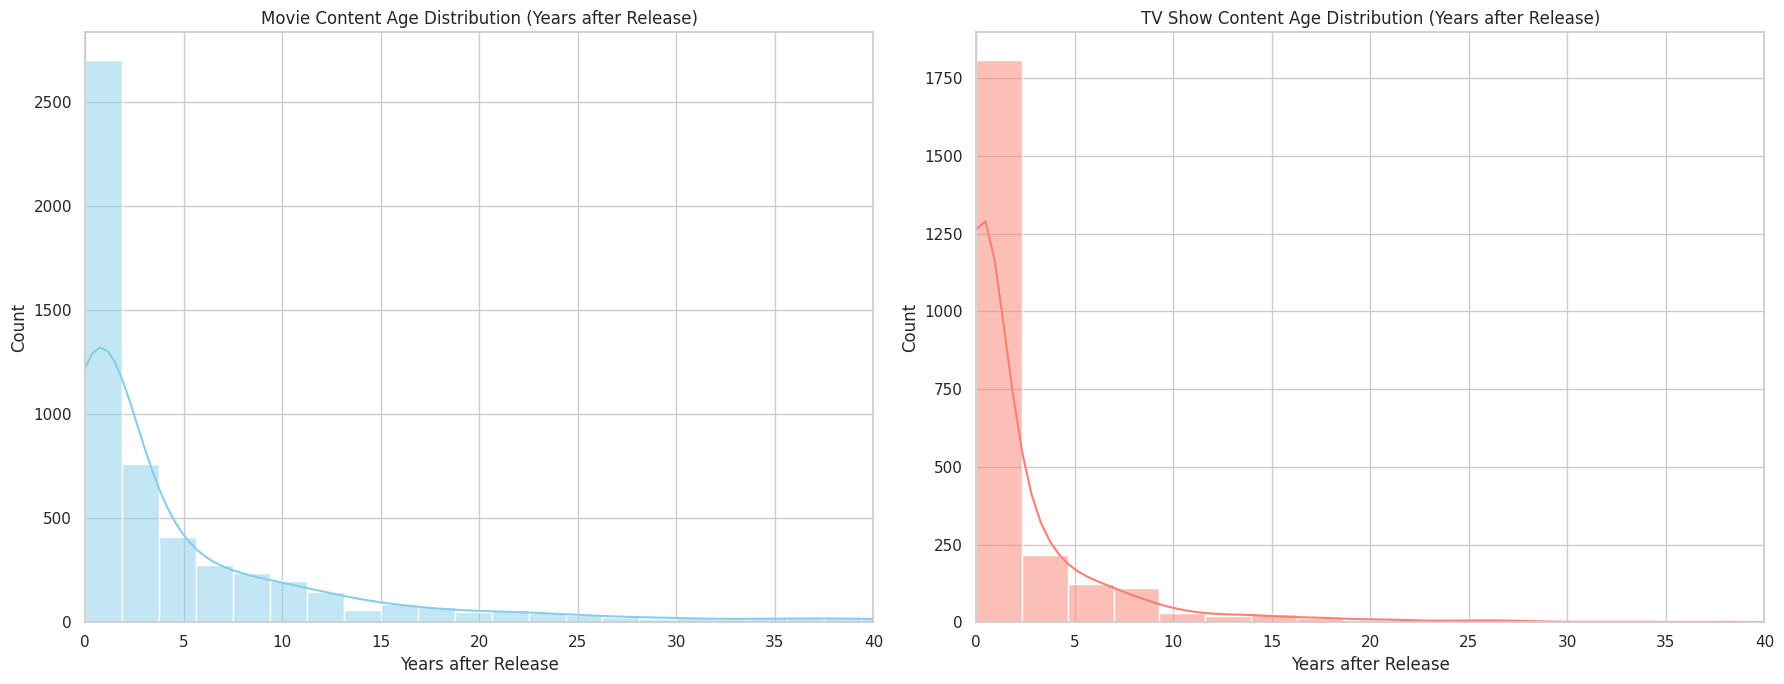

In [75]:
df['content_age'] = df['year_added'] - df['release_year']
content_age = df[df['content_age'] >= 0]
movies_df = content_age[content_age['type'] == 'Movie']
tv_shows_df = content_age[content_age['type'] == 'TV Show']

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(
    ax=axes[0],
    data=movies_df,
    x='content_age',
    bins=40,
    kde=True,
    color='skyblue'
).set_title('Movie Content Age Distribution (Years after Release)')

sns.histplot(
    ax=axes[1],
    data=tv_shows_df,
    x='content_age',
    bins=40,
    kde=True,
    color='salmon'
).set_title('TV Show Content Age Distribution (Years after Release)')


for ax in axes:
    ax.set_xlabel('Years after Release')
    ax.set_ylabel('Count')
    ax.set_xlim(0, 40)

plt.tight_layout()
plt.show()


### Q3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?

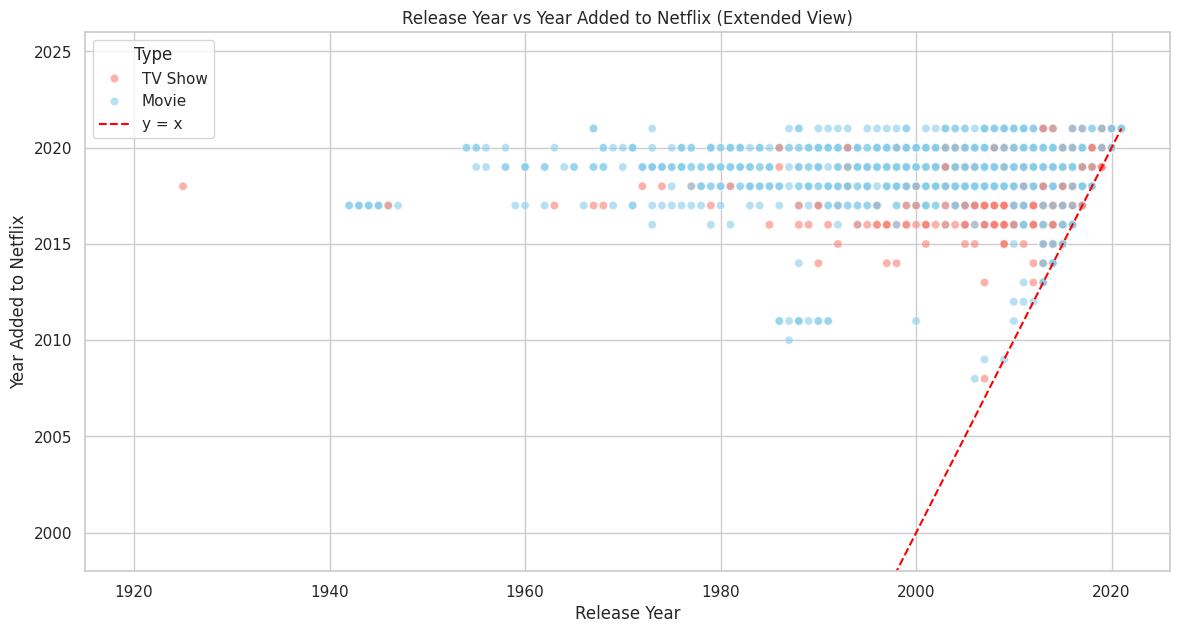

In [80]:
plt.figure(figsize=(14,7))
sns.scatterplot(
    data=content_age,
    x='release_year',
    y='year_added',
    hue='type',
    alpha=0.6,
    palette={'Movie':'skyblue','TV Show':'salmon'}
)

plt.plot([content_age['release_year'].min(), content_age['release_year'].max()],
         [content_age['release_year'].min(), content_age['release_year'].max()],
         color='red', linestyle='--', label='y = x')

plt.xlim(content_age['release_year'].min()-10, content_age['release_year'].max()+5)
plt.ylim(content_age['year_added'].min()-10, content_age['year_added'].max()+5)

plt.title("Release Year vs Year Added to Netflix (Extended View)")
plt.xlabel("Release Year")
plt.ylabel("Year Added to Netflix")
plt.legend(title="Type")
plt.show()


Recent movies and TV shows are typically added to Netflix shortly after their release, resulting in a content age close to zero. In contrast, classic movies and older TV shows tend to be added several years after their original release, with a content age greater than five. TV shows are sometimes added season by season, which can lead to multiple entries for different years. Movies, on the other hand, usually have a single entry per title and are often added in batches, particularly for older content.

### Q4. What are the most common word pairs or phrases in content descriptions?

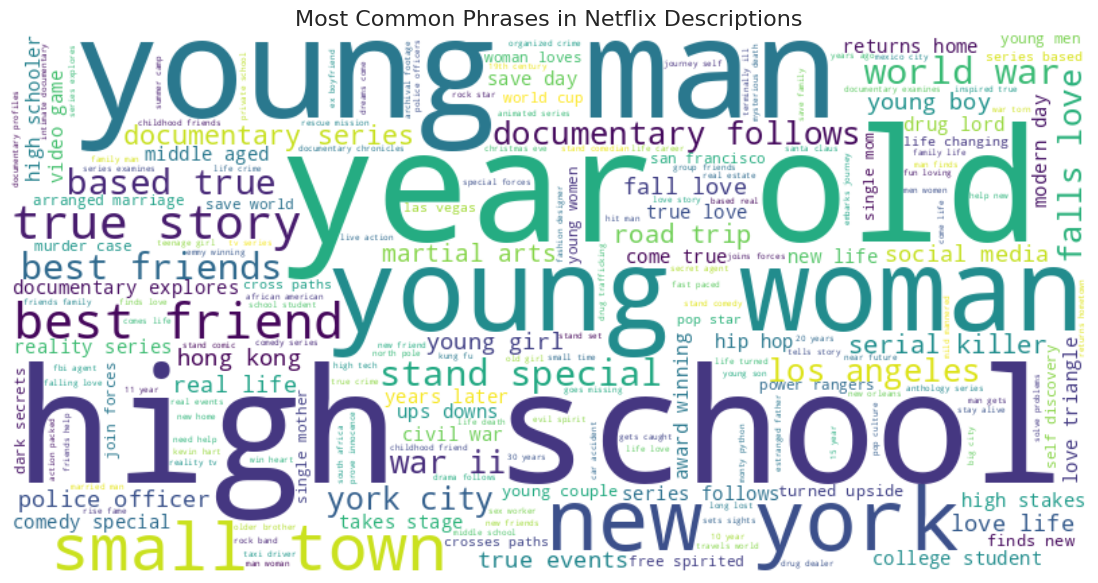

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(df['description'].dropna())

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Phrases in Netflix Descriptions", fontsize=16)
plt.show()

### Q5. Who are the top directors on Netflix?

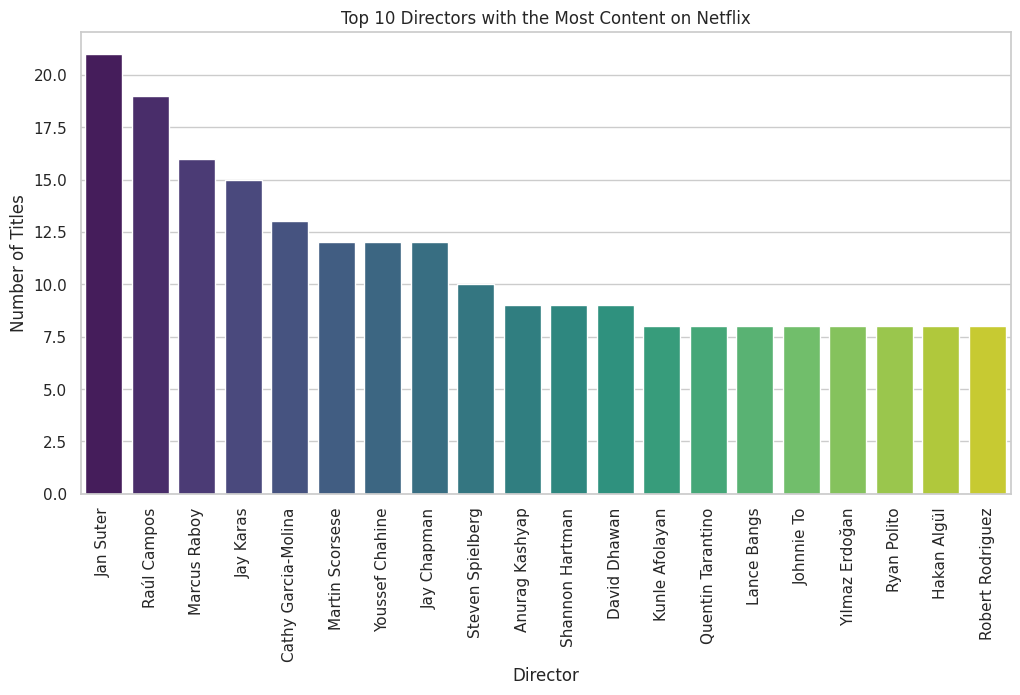

In [113]:
directors = df['director']
directors = directors[directors.str.strip().str.lower() != 'unknown']
directors = directors[directors.str.strip() != ""]


directors_split = directors.str.split(',').explode().str.strip()
df_dir = directors_split.value_counts().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_dir.head(20),
    x='director',
    y='count',
    hue='director',
    palette='viridis'
)
plt.title("Top 10 Directors with the Most Content on Netflix")
plt.xlabel("Director")
plt.ylabel("Number of Titles")
plt.xticks(rotation=90)
plt.show()